In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

data_path = '/content/drive/MyDrive/DLS_PROJECT/AGENT/data/data_final_for_dls_new.jsonl'
eval_path = '/content/drive/MyDrive/DLS_PROJECT/AGENT/data/data_final_for_dls_eval_new.jsonl'
data = pd.read_json(path_or_buf=data_path, lines=True)

test_data = pd.read_json(path_or_buf=eval_path, lines=True)

In [ ]:
data.head(3)

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance,reviews_summarized,relevance_new
0,сигары,"Москва, Дубравная улица, 34/29",Tabaccos; Магазин Tabaccos; Табаккос,Магазин табака и курительных принадлежностей,1263329400,None,1.0,"Организация занимается продажей табака, курите...",1.0
1,кальянная спб мероприятия,"Санкт-Петербург, Большой проспект Петроградско...",PioNero; Pionero; Пицца Паста бар; Pio Nero; P...,Кафе,228111266197,PioNero предлагает разнообразные блюда итальян...,0.0,"Организация PioNero — это кафе, бар и ресторан...",0.0
2,Эпиляция,"Московская область, Одинцово, улица Маршала Жу...",MaxiLife; Центр красоты и здоровья MaxiLife; Ц...,Стоматологическая клиника,1247255817,"Стоматологическая клиника, массажный салон и к...",1.0,"Организация занимается стоматологическими, кос...",1.0


In [ ]:
data['relevance_new'].value_counts(normalize=True)

,proportion
relevance_new,
1.0,0.454494
0.0,0.411495
0.1,0.134012


*Объеденим 1.0 и 0.1 в один класс 1*
* 0.0 - не релевантно    (class: 0)
* 0.1 - слабо релевантно (class: 1)
* 1.0 - явно релевантно  (class: 1)


In [ ]:
data['relevance_new'] = data['relevance_new'].map({0.0: 0, 0.1: 1, 1.0: 1}).astype(int)

train_data, val_data = train_test_split(data, test_size=0.15, random_state=42)
test_data['relevance_new'] = test_data['relevance_new'].map({0.0: 0, 0.1: 1, 1.0: 1}).astype(int)


In [ ]:
data['relevance_new'].value_counts(normalize=True)

,proportion
relevance_new,
1,0.588505
0,0.411495


In [ ]:
data.head(3)

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance,reviews_summarized,relevance_new
0,сигары,"Москва, Дубравная улица, 34/29",Tabaccos; Магазин Tabaccos; Табаккос,Магазин табака и курительных принадлежностей,1263329400,None,1.0,"Организация занимается продажей табака, курите...",1
1,кальянная спб мероприятия,"Санкт-Петербург, Большой проспект Петроградско...",PioNero; Pionero; Пицца Паста бар; Pio Nero; P...,Кафе,228111266197,PioNero предлагает разнообразные блюда итальян...,0.0,"Организация PioNero — это кафе, бар и ресторан...",0
2,Эпиляция,"Московская область, Одинцово, улица Маршала Жу...",MaxiLife; Центр красоты и здоровья MaxiLife; Ц...,Стоматологическая клиника,1247255817,"Стоматологическая клиника, массажный салон и к...",1.0,"Организация занимается стоматологическими, кос...",1


In [ ]:
data.columns

Index(['Text', 'address', 'name', 'normalized_main_rubric_name_ru',
       'permalink', 'prices_summarized', 'relevance', 'reviews_summarized',
       'relevance_new'],
      dtype='object')

In [ ]:
def build_text(df):
  res = pd.DataFrame(
      df['Text'].fillna("") + ' [SEP] ' + df['name'].fillna("") + ' ' +
      df['normalized_main_rubric_name_ru'].fillna('') + ' ' +
      df['reviews_summarized'].fillna(""),
      columns=['texts']
  )
  return res

In [ ]:
X_train = build_text(train_data)
y_train = train_data['relevance_new']

X_val = build_text(val_data)
y_val = val_data['relevance_new']

X_test = build_text(test_data)
y_test = test_data['relevance_new']

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier


pip_lr = Pipeline([
    ('vectorizer',TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9, sublinear_tf=True)),
    ('clf', SGDClassifier(
        loss='log_loss',
        penalty='elasticnet',
        alpha=1e-4,
        l1_ratio=0.15,
        early_stopping=False,
        validation_fraction=0.1,
        n_iter_no_change=5,
        class_weight='balanced',
        random_state=42))
    ])

pip_lr.fit(X_train['texts'], y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('clf',
                 SGDClassifier(class_weight='balanced', loss='log_loss',
                               penalty='elasticnet', random_state=42))])

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
def scor_func(model, model_name: str):
    print(f'Model_name: {model_name}')

    predict_t = model.predict(X_train['texts'])
    predict_v = model.predict(X_val['texts'])

    print(f'REPORT TRAIN\n')
    print(classification_report(y_train, predict_t))
    print(f'REPORT VAL\n')
    print(classification_report(y_val, predict_v))

    if hasattr(model, "predict_proba"):
        proba_t = model.predict_proba(X_train['texts'])[:, 1]
        proba_v = model.predict_proba(X_val['texts'])[:, 1]

        print(f'ROC-AUC TRAIN: {roc_auc_score(y_train, proba_t):.3f}')
        print(f'PR-AUC TRAIN:  {average_precision_score(y_train, proba_t):.3f}')

        print(f'ROC-AUC VAL: {roc_auc_score(y_val, proba_v):.3f}')
        print(f'PR-AUC VAL:  {average_precision_score(y_val, proba_v):.3f}')
    else:
        print("Model does not support predict_proba")


In [ ]:
scor_func(pip_lr, model_name='lr')

Model_name: lr
REPORT TRAIN

              precision    recall  f1-score   support

           0       0.55      0.68      0.61     12287
           1       0.73      0.61      0.66     17542

    accuracy                           0.64     29829
   macro avg       0.64      0.64      0.64     29829
weighted avg       0.66      0.64      0.64     29829

REPORT VAL

              precision    recall  f1-score   support

           0       0.51      0.66      0.58      2154
           1       0.71      0.57      0.63      3111

    accuracy                           0.61      5265
   macro avg       0.61      0.61      0.60      5265
weighted avg       0.63      0.61      0.61      5265

ROC-AUC TRAIN: 0.702
PR-AUC TRAIN:  0.755
ROC-AUC VAL: 0.657
PR-AUC VAL:  0.723


Попробуем SVM

In [ ]:
pip_svm = Pipeline([
    ('vectorizer',TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9, sublinear_tf=True)),
    ('clf', SGDClassifier(
        loss='hinge',
        penalty='elasticnet',
        alpha=1e-4,
        l1_ratio=0.15,
        early_stopping=False,
        validation_fraction=0.1,
        n_iter_no_change=5,
        class_weight='balanced',
        random_state=42))
    ])

pip_svm.fit(X_train['texts'], y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('clf',
                 SGDClassifier(class_weight='balanced', penalty='elasticnet',
                               random_state=42))])

In [ ]:
scor_func(pip_svm, model_name='SVM')

Model_name: SVM
REPORT TRAIN

              precision    recall  f1-score   support

           0       0.54      0.73      0.62     12287
           1       0.75      0.57      0.65     17542

    accuracy                           0.64     29829
   macro avg       0.65      0.65      0.63     29829
weighted avg       0.67      0.64      0.64     29829

REPORT VAL

              precision    recall  f1-score   support

           0       0.51      0.70      0.59      2154
           1       0.72      0.53      0.61      3111

    accuracy                           0.60      5265
   macro avg       0.61      0.61      0.60      5265
weighted avg       0.63      0.60      0.60      5265

Model does not support predict_proba


Попробуем ``Catboost``

In [ ]:
tfidf = TfidfVectorizer(
    ngram_range=(1,2),       # улавливаем пары слов
    min_df=3,                # игнорируем редкие токены
    max_df=0.85,             # игнорируем слишком частые
    max_features=65000,      # ограничиваем размер матрицы
    sublinear_tf=True,       # логарифмируем tf
    lowercase=True,
    strip_accents='unicode',
    token_pattern=r'\b\w\w+\b'
)

X_train_tfidf = tfidf.fit_transform(X_train['texts'].fillna(''))
X_val_tfidf   = tfidf.transform(X_val['texts'].fillna(''))

In [ ]:
from catboost import CatBoostClassifier

# Параметры этапов: (iterations, learning_rate, l2_leaf_reg)
training_stages = [
    (300, 0.05, 3),   # этап 1: крупный шаг, слабая регуляризация
    (300, 0.01, 5),   # этап 2: шаг меньше, регуляризация сильнее
    (400, 0.005, 8)   # этап 3: мелкий шаг, сильная регуляризация
]

init_model = None

for i, (iters, lr, l2_reg) in enumerate(training_stages, 1):
    print(f"\n=== Stage {i}: iterations={iters}, learning_rate={lr}, l2_leaf_reg={l2_reg} ===")

    cb = CatBoostClassifier(
        iterations=iters,
        learning_rate=lr,
        depth=6,
        loss_function='Logloss',
        eval_metric='AUC',
        bagging_temperature=1.0,
        subsample=0.8,
        rsm=0.8,
        l2_leaf_reg=l2_reg,
        auto_class_weights="Balanced",
        early_stopping_rounds=100,
        use_best_model=True,
        verbose=50
    )

    cb.fit(
        X_train_tfidf, y_train,
        eval_set=(X_val_tfidf, y_val),
        init_model=init_model
    )

    # следующий этап будет инициализирован этой моделью
    init_model = cb

print("\nОбучение завершено!")


=== Stage 1: iterations=300, learning_rate=0.05, l2_leaf_reg=3 ===
0:	test: 0.5737292	best: 0.5737292 (0)	total: 4.55s	remaining: 22m 40s
50:	test: 0.6328125	best: 0.6328125 (50)	total: 3m 31s	remaining: 17m 10s
100:	test: 0.6482586	best: 0.6483818 (93)	total: 6m 52s	remaining: 13m 33s
150:	test: 0.6565667	best: 0.6565667 (150)	total: 10m 13s	remaining: 10m 5s
200:	test: 0.6633277	best: 0.6633277 (200)	total: 13m 35s	remaining: 6m 41s
250:	test: 0.6685411	best: 0.6685411 (250)	total: 16m 55s	remaining: 3m 18s
299:	test: 0.6731977	best: 0.6732728 (298)	total: 21m 6s	remaining: 0us

bestTest = 0.6732728268
bestIteration = 298

Shrink model to first 299 iterations.

=== Stage 2: iterations=300, learning_rate=0.01, l2_leaf_reg=5 ===
0:	test: 0.6733048	best: 0.6733048 (0)	total: 6.17s	remaining: 30m 45s
50:	test: 0.6734153	best: 0.6734153 (50)	total: 3m 34s	remaining: 17m 24s
100:	test: 0.6738260	best: 0.6738513 (96)	total: 6m 56s	remaining: 13m 39s
150:	test: 0.6738824	best: 0.6739338 (12

Cоберем теперь обученный tf_idf векторизатор и катбуст в один пайплайн

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class CatBoostPipeline(BaseEstimator, ClassifierMixin):
    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model

    def __repr__(self):
        return f"CatBoostPipeline(vectorizer={self.vectorizer}, model={self.model})"

    def fit(self, X=None, y=None):
        # ничего не обучаем — модель уже обучена
        return self

    def _transform(self, X):
        return self.vectorizer.transform(X.fillna(''))

    def predict(self, X):
        X_vec = self._transform(X)
        return self.model.predict(X_vec)

    def predict_proba(self, X):
        X_vec = self._transform(X)
        return self.model.predict_proba(X_vec)

cb_pipe = CatBoostPipeline(vectorizer=tfidf, model=cb)
cb_pipe

CatBoostPipeline(vectorizer=TfidfVectorizer(max_df=0.85, max_features=65000, min_df=3, ngram_range=(1, 2),
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\b\\w\\w+\\b'), model=<catboost.core.CatBoostClassifier object at 0x79ac6d507fb0>)

In [ ]:
scor_func(cb_pipe, model_name=f'Catboost')

Model_name: Catboost
REPORT TRAIN

              precision    recall  f1-score   support

           0       0.58      0.74      0.65     12287
           1       0.77      0.62      0.69     17542

    accuracy                           0.67     29829
   macro avg       0.67      0.68      0.67     29829
weighted avg       0.69      0.67      0.67     29829

REPORT VAL

              precision    recall  f1-score   support

           0       0.52      0.67      0.58      2154
           1       0.71      0.57      0.63      3111

    accuracy                           0.61      5265
   macro avg       0.62      0.62      0.61      5265
weighted avg       0.63      0.61      0.61      5265

ROC-AUC TRAIN: 0.753
PR-AUC TRAIN:  0.804
ROC-AUC VAL: 0.676
PR-AUC VAL:  0.742


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'PRECISION ON VAL: {precision_score(y_val, cb_pipe.predict(X_val['texts'])):.3f}')
print(f'PRECISION ON TEST: {precision_score(y_test, cb_pipe.predict(X_test['texts'])):.3f}')
print()
print(f'RECALL ON VAL: {recall_score(y_val, cb_pipe.predict(X_val['texts'])):.3f}')
print(f'RECALL ON TEST: {recall_score(y_test, cb_pipe.predict(X_test['texts'])):.3f}')
print()
print(f'F1 ON VAL: {f1_score(y_val, cb_pipe.predict(X_val['texts'])):.3f}')
print(f'F1 ON TEST: {f1_score(y_test, cb_pipe.predict(X_test['texts'])):.3f}')

PRECISION ON VAL: 0.713
PRECISION ON TEST: 0.819

RECALL ON VAL: 0.568
RECALL ON TEST: 0.594

F1 ON VAL: 0.633
F1 ON TEST: 0.689


Посчитаем доверительный интервал

In [ ]:
import numpy as np

def bootstrap_metric(y_true, y_pred, metric, n=1000):
    vals = []
    idx = np.arange(len(y_true))
    for _ in range(n):
        sample = np.random.choice(idx, size=len(idx), replace=True)
        vals.append(metric(y_true[sample], y_pred[sample]))
    return np.percentile(vals, [5, 50, 95])

In [ ]:
bootstrap_metric(
    y_test.values,
    cb_pipe.predict(X_test['texts']),
    precision_score
)

array([0.78136201, 0.81914894, 0.856062  ])

In [ ]:
bootstrap_metric(
    y_val.values,
    cb_pipe.predict(X_val['texts']),
    precision_score
)

array([0.69865216, 0.71330361, 0.72819886])

То есть мой **Precision** на тестовых данных лежит в диапазоне **[0.78, 0.86]**,  
а на валидационных данных в диапазоне **[0.69, 0.73]**.

Это различие объясняется несколькими факторами:

- Размер выборок: тестовая выборка маленькая (570 объектов), поэтому метрика более вариативна, а валидационная большая (5200 объектов) — оценки стабильнее.
- Случайные различия данных: даже при одинаковой модели небольшие отличия в распределении классов и признаков влияют на метрики.
- Бутстрэп-разброс: на малой выборке интервалы точности шире.

**Вывод:** несмотря на различие диапазонов, средние показатели на тесте и валидации сопоставимы, что подтверждает корректность работы модели.


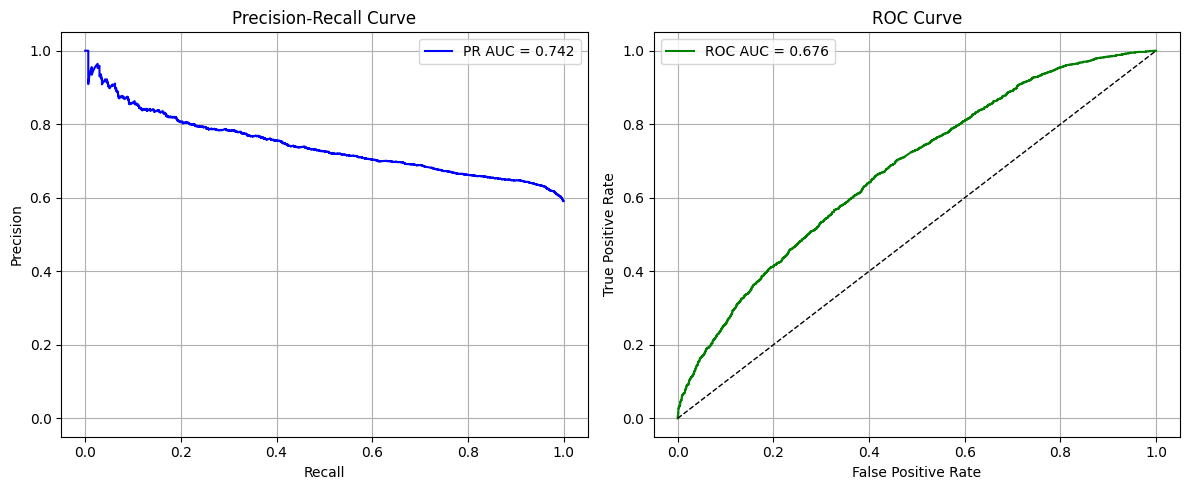

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

proba = cb_pipe.predict_proba(X_val['texts'])[:, 1]

# PR-кривая
precision, recall, thresholds = precision_recall_curve(y_val, proba)
pr_auc = auc(recall, precision)

# ROC-кривая
fpr, tpr, _ = roc_curve(y_val, proba)
roc_auc = auc(fpr, tpr)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# PR
axes[0].plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}', color='blue')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve')
axes[0].set_ylim(-0.05, 1.05)
axes[0].legend()
axes[0].grid(True)
# ROC
axes[1].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}', color='green')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


Отберем порог отсечки по PR кривой

будем брать по максимуму f1 меры

In [ ]:
f1 = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-9)
f1[precision[:-1] < 0.75] = 0   # все что ниже по точности 0.75 не рассматриваем
best_idx = np.argmax(f1)

best_threshold = thresholds[best_idx]
best_precision = precision[best_idx]
best_recall = recall[best_idx]
best_f1 = f1[best_idx]

print(f'Best threshold: {best_threshold:.3f}')
print(f'Best precision: {best_precision:.3f}')
print(f'Best recall: {best_recall:.3f}')
print(f'Best F1: {best_f1:.3f}')

Best threshold: 0.545
Best precision: 0.750
Best recall: 0.413
Best F1: 0.533


In [ ]:
best_threshold.item()

0.544712165501078

Мы используем порог 0.545, чтобы обеспечить `precision ≥ 0.75`.

Это снижает `recall до ~0.41`, но уменьшает количество ложных срабатываний, что важно для нашей задачи.

------
Сохраним модель

In [ ]:
import joblib

joblib.dump(cb_pipe, 'catboost_pipeline.pkl')

['catboost_pipeline.pkl']

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import joblib

class CatBoostPipeline(BaseEstimator, ClassifierMixin):
    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model

    def __repr__(self):
        return f"CatBoostPipeline(vectorizer={self.vectorizer}, model={self.model})"

    def fit(self, X=None, y=None):
        # ничего не обучаем — модель уже обучена
        return self

    def _transform(self, X):
        return self.vectorizer.transform(X.fillna(''))

    def predict(self, X):
        X_vec = self._transform(X)
        return self.model.predict(X_vec)

    def predict_proba(self, X):
        X_vec = self._transform(X)
        return self.model.predict_proba(X_vec)

catboost_path = '/content/drive/MyDrive/DLS_PROJECT/AGENT/catboost_pipeline.pkl'
cb = joblib.load(catboost_path)
cb

CatBoostPipeline(vectorizer=TfidfVectorizer(max_df=0.85, max_features=65000, min_df=3, ngram_range=(1, 2),
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\b\\w\\w+\\b'), model=<catboost.core.CatBoostClassifier object at 0x7ea8dbe55fa0>)

In [ ]:
import dill
with open('catboost_pipeline.pkl', 'wb') as f:
    a = dill.dump(cb, f)


In [ ]:
clf_file = f'/content/catboost_pipeline.pkl'
with open(clf_file, 'rb') as f:
  a = dill.load(f)

In [ ]:
a

CatBoostPipeline(vectorizer=TfidfVectorizer(max_df=0.85, max_features=65000, min_df=3, ngram_range=(1, 2),
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\b\\w\\w+\\b'), model=<catboost.core.CatBoostClassifier object at 0x7ea8caa92ab0>)